# Bandgap Design
A progressive documentation of a bangdap design in the Skywater 130 nm process

In [1]:
%load_ext autoreload
%autoreload 2

In [124]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
import SpiceInterface

## Investigate Process PNPs
Let's begin by investigating the behaviour of the Skywater 130 nm 'sky130_fd_pr__pnp_05v5_W3p40L3p40' PNP devices

### PNP IV Characteristics
To start lets view the IV (Current/Voltage) relationship of the PNP device.

This follows the well known Shockley diode equation:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ I_D = I_S \left( e^{\frac{V_D}{n V_T}} - 1 \right) $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; where $ V_T = \frac{k T}{q} $

This can be inverted to express the diode voltage:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ V_D = n V_T \cdot ln \left( \frac{I_D}{I_S} + 1 \right) $

The logarithmic behaviour of the diode voltage with respect to current can clearly be seen below.

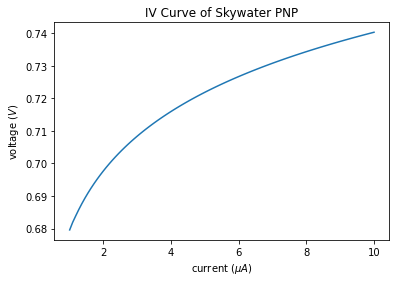

In [3]:
spice_interface_obj = SpiceInterface.SpiceInterface(netlist_path='../test/bjt_test.spice', verbose=False)

results = spice_interface_obj.sweep_parameter('ianode', 1e-6, 10e-6, 101, ['i(vvdd)', 'v(anode)'], 
                                                sweeptype='dcsweep')
plt.plot([-_*1e6 for _ in results['i(vvdd)']], results['v(anode)'])

plt.ylabel('voltage ($V$)')
plt.xlabel('current ($\mu A$)')
plt.title('IV Curve of Skywater PNP')
plt.show()

#### $V_D$ Over Temperature
We can see from the Shockley diode equation that the exponential term has a positive temperature coefficient in the $ V_T $ term. The higher the temperature the greater the voltage drop.

However, when examining the temperature behaviour ($\frac{\partial V_D}{\partial T}$) we see a negative temperature coefficient, often reffered to as Complimentary to Absolute Temperature (CTAT). The higher the temperature the lower the diode voltage. This behaviour can be seen below.

###### Saturation Current Contribution
Where does this surprising result come from? The answer is in the diodes saturation current, $I_S$. Which itself has a temperature coefficient.

Expanding the Schockley diode equation further we find the expression for the saturation current is:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ {\displaystyle I_{\text{S}}=eAn_{\text{i}}^{2}\left({\frac {1}{N_{\text{D}}}}{\sqrt {\frac {D_{\text{p}}}{\tau _{\text{p}}}}}+{\frac {1}{N_{\text{A}}}}{\sqrt {\frac {D_{\text{n}}}{\tau _{\text{n}}}}}\right)} $

Here we start to see some of the fundamental parameters of semiconductor manufacturing such as doping concentrations, diffusion coefficients and carrier lifetimes.

As the temperature rises the number of free carriers rises as every carrier in the device has a greater energy. This increase in conductivity leads to a lower voltage across the junction for a given foward current. Therefore, for a constant current the voltage of the diode junction reduces with rising temperature.


MORE STUFF

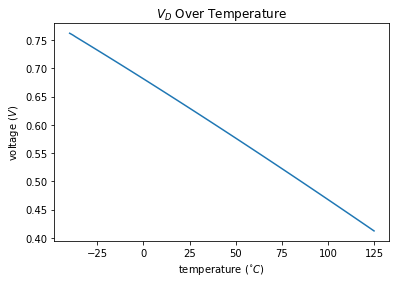

In [14]:
results = spice_interface_obj.sweep_parameter('temp', start=-40, end=125, number_steps=101,
                                                signals=['v(anode)', 'temp'], sweeptype='dcsweep')

plt.plot(results['temp'], results['v(anode)'])
plt.xlabel('temperature ($^{\circ} C$)')
plt.ylabel('voltage ($V$)')
plt.title('$V_{D}$ Over Temperature')
plt.show()

We can see the CTAT coefficient of $-1.94~mV/K$ is close to the theoretical value of $-2.00~mV/K$.

###### Difference of Diode Voltages
Consider what the temperature coefficient of the difference of two diode voltages is. Of course, two identical diodes will have no voltage differences but if the diodes have different current densities something else occurs:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ V_\Delta = n V_T \cdot ln \left( \frac{I_{D_1}}{I_S} + 1 \right) - n V_T \cdot ln \left( \frac{I_{D_2}}{I_S} + 1 \right) $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ V_\Delta = n V_T \cdot \left[ ln \left( \frac{I_{D_1}}{I_S} + 1 \right) - ln \left( \frac{I_{D_2}}{I_S} + 1 \right) \right]$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ V_\Delta = n V_T \cdot ln \left( \frac{\frac{I_{D_1}}{I_S} + 1}{\frac{I_{D_2}}{I_S} + 1} \right) $

As part of the design we ensure that the bias current is much greater than the saturation current and therefore the expression can be simplified to:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ V_\Delta = n V_T \cdot ln \left( \frac{\frac{I_{D_1}}{I_S}}{\frac{I_{D_2}}{I_S}} \right) $

We then ensure the two diodes are well matched leading to:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ V_\Delta = n V_T \cdot ln \left( \frac{I_{D_1}}{I_{D_2}} \right) $

Or more simply:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ V_\Delta = n V_T \cdot ln \left( A_M \right) $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; where $A_M$ is the ratio of current density of the diodes.

Importantly the only temperature dependance now is in the $V_T$ term which is a postive temperature coefficient, or PTAT (Proportional To Absolute Temperature).


The positive temperature coefficient is $kT$ or $\frac{\partial V}{\partial T} \approx +0.086~mV/K$. Compared with the negative temperature coefficient which is $\approx -2~mV/K$.

Lets assume that the ratio of the current densities is 8. Then plot the temperature coefficients.

We can see a PTAT coefficient of $+ 0.182~mV/K$ which is close to the theoretical value of $ ln(8) \cdot 0.086 = +0.179~mV/K$

In [5]:
results_m1 = spice_interface_obj.sweep_parameter('temp', start=-40, end=125, number_steps=101,
                                                    signals=['v(anode)', 'temp'], sweeptype='dcsweep')
spice_interface_obj.set_parameters([['m', 8]])
results_m8 = spice_interface_obj.sweep_parameter('temp', start=-40, end=125, number_steps=101,
                                                    signals=['v(anode)', 'temp'], sweeptype='dcsweep')

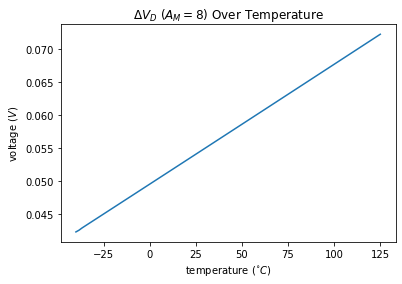

In [9]:
plt.plot(results_m1['temp'], 
         [m1_i - m8_i for m1_i, m8_i in zip(results_m1['v(anode)'], results_m8['v(anode)'])])
plt.xlabel('temperature ($^{\circ} C$)')
plt.ylabel('voltage ($V$)')
plt.title('$\Delta V_{D}$ ($A_M = 8$) Over Temperature')
plt.show()

#### Combining PTAT and CTAT Sources
Now we have the basis for out temperature independant source, a PTAT and a CTAT. If we combine scaled versions of these coefficients they will cancel out leaving a temperature independant reference - to the first order, other second order effects will still be present.



Let's convert these voltage sources to currents which can be easily handled in CMOS technologogies by placing resistors across the voltage sources. The resistor values can then be used to scale the currents and set the compensation and absolute values as required.

###### PTAT
Feedback is used to alter the current through through the two diode connected PNPs until $v(node1)$ is equal to $v(node2)$. At this point PTAT voltage, $\Delta V_D$ is across the resistor $R1$ and thus $I_{R_1} = \frac{V_T \cdot ln \left( A_M \right)}{R_1} = \frac{V_T \cdot ln \left( 8 \right)}{R_1} = \frac{179~\mu V \cdot T}{R_1}$.

The temperature coefficient is then $\frac{\partial I_{R_1}}{\partial T} = +\frac{182}{R_1}~\mu A/K$

###### CTAT
Feedback is used control the current through $R_2$ until it's voltage matches the diode connected PNP voltage. Thus, the current is given by $I_{R_2} = \frac{ V_T \cdot ln \left( \frac{I_D}{I_S} + 1 \right)}{R_2} $

The temperature coefficient is then $\frac{\partial I_{R_2}}{\partial T} = -\frac{1940}{R_2}~\mu A/K$

###### Compensation

To remove the temperature effect we need to set $\|\frac{\partial I_{R_1}}{\partial T}\| = \|\frac{\partial I_{R_2}}{\partial T}\|$ so that when the two current sources are summed the resulting current has no temperature dependance.

Therefore, we can easily derive the relationship for the resistor values, $\frac{R_2}{R_1} = \frac{1940}{182} = 10.66 $.

#### Simulate Ideal Bandgap
Let's simulate the bandgap using ideal feedback elements to see the performance.
Note that there are two stable operating points, the desired reference point and when all currents are equal to zero. Therefore, a startup circuit is included in the circuit.

In [104]:
spice_interface_obj = SpiceInterface.SpiceInterface(netlist_path='../test/ideal_bandgap_test.spice', 
                                                    verbose=False)

spice_interface_obj.set_parameters([['R1', 6.9e3],['R2', 61.0e3]])

results = spice_interface_obj.sweep_parameter('temp', start=-40, end=125, number_steps=101,
                            signals=['v(node1)', 'v(node2)', 'v(node3)', 'temp', 'i(@g1[i])', 'i(@g3[i])'], 
                            sweeptype='dcsweep')

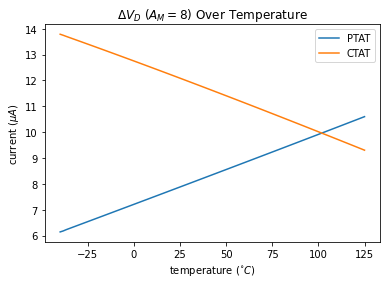

In [105]:
plt.plot(results['temp'], [_*1e6 for _ in results['i(@g1[i])']])
plt.plot(results['temp'], [_*1e6 for _ in results['i(@g3[i])']])
plt.legend(['PTAT', 'CTAT'])
plt.xlabel('temperature ($^{\circ} C$)')
plt.ylabel('current ($\mu A$)')
plt.title('$\Delta V_{D}$ ($A_M = 8$) Over Temperature')
plt.show()

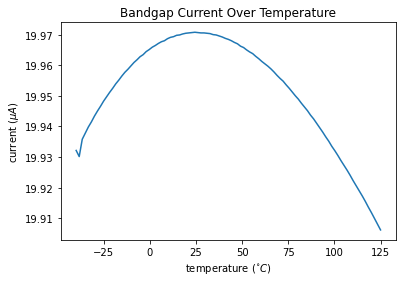

In [107]:
plt.plot(results['temp'], 
         [1e6*(g1_i + g3_i) for g1_i, g3_i in zip(results['i(@g1[i])'], results['i(@g3[i])'])])
plt.xlabel('temperature ($^{\circ} C$)')
plt.ylabel('current ($\mu A$)')
plt.title('Bandgap Current Over Temperature')
plt.show()

In [147]:
bg_curr = [1e6*(g1_i + g3_i) for g1_i, g3_i in zip(results['i(@g1[i])'], results['i(@g3[i])'])]
display(Markdown("Bandgap current at $26^{\circ}C$: $%0.3f \mu A$" % bg_curr[40]))
display(Markdown("Current change at $-40^{\circ}C$: $%0.3f \%%$ " % ( 100*(bg_curr[0]-bg_curr[40])/bg_curr[40]) ))
display(Markdown("Current change at $125^{\circ}C$: $%0.3f \%%$ " % ( 100*(bg_curr[-1]-bg_curr[40])/bg_curr[40]) ))

Bandgap current at $26^{\circ}C$: $19.971 \mu A$

Current change at $-40^{\circ}C$: $-0.193 \%$ 

Current change at $125^{\circ}C$: $-0.323 \%$ 

##  Current Mirror


### References
This has been supported by the following material:

['How to Make a Bandgap Voltage Reference in One Eeasy Lesson'](https://www.idt.com/eu/en/document/whp/how-make-bandgap-voltage-reference-one-easy-lesson-paul-brokaw) - A. Paul Brokaw

['The Bandgap Reference'](http://www.seas.ucla.edu/brweb/papers/Journals/BRSummer16Bandgap.pdf) - B. Razavi

['134N. Scaled bandage reference, adjustable voltage PVT independent references.'](https://www.youtube.com/watch?v=AMgrGvzCTck) - A. Hajimiri

And of course, the mighty [Wikipedia](https://www.wikipedia.org)